In [1]:
import blaze as bz
import numpy as np
import pandas as pd
import sqlite3
import itertools

from zipline.data import bundles
from zipline.utils.calendars import get_calendar

from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.data import DataSet
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.blaze import BlazeLoader, from_blaze


trading_calendar = get_calendar('NYSE')
bundle_data = bundles.load('quandl')
#bundle_data = bundles.load('sharadar-prices')

# spoof some data

np.random.seed(100)

start = trading_calendar.closes.index.get_loc('2016-01-04 00:00:00+00:00')
end = trading_calendar.closes.index.get_loc('2018-08-06 00:00:00+00:00')

#dates = list(trading_calendar.closes.index)[start:end]
dates = trading_calendar.closes.index[start:end]
sids = bundle_data.asset_finder.sids

df = pd.DataFrame(
    data={'value': np.random.random(size=len(dates)*len(sids))},
    index = pd.MultiIndex.from_tuples(list(itertools.product(dates,sids)), names=('asof_date', 'sid'))
)

/home/ubuntu/anaconda3/envs/env_hca_live/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/env_hca_live/lib/python3.6/site-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


AttributeError: module 'pandas' has no attribute 'computation'

In [2]:
len(sids)
#df.head()
#bundle_data.equity_daily_bar_reader.trading_calendar.closes

3199

In [3]:
df = df.reset_index()

In [4]:
# this is necessary because sqlite3 doesn't like it if we have the time
df.asof_date = df.asof_date.dt.date

In [5]:
df.head()

,asof_date,sid,value
0,2016-01-04,0,0.543405
1,2016-01-04,1,0.278369
2,2016-01-04,2,0.424518
3,2016-01-04,3,0.844776
4,2016-01-04,4,0.004719


In [6]:
# put into sqlite db
df.to_sql('ds_table', con=sqlite3.connect('temp.db'), if_exists='replace', index=False)

In [7]:
con = sqlite3.connect('temp.db')
cursor = con.cursor()
cursor.execute("SELECT * FROM ds_table LIMIT 10")
print(cursor.fetchall())

[('2016-01-04', 0, 0.5434049417909654), ('2016-01-04', 1, 0.27836938509379616), ('2016-01-04', 2, 0.4245175907491331), ('2016-01-04', 3, 0.8447761323199037), ('2016-01-04', 4, 0.004718856190972565), ('2016-01-04', 5, 0.12156912078311422), ('2016-01-04', 6, 0.6707490847267786), ('2016-01-04', 7, 0.8258527551050476), ('2016-01-04', 8, 0.13670658968495297), ('2016-01-04', 9, 0.57509332942725)]


In [8]:
from datashape import dshape

In [9]:
ds_dshape = dshape("var*{asof_date: datetime, sid: int64, value: float64}")

In [10]:
ds_dshape

dshape("var * {asof_date: datetime, sid: int64, value: float64}")

In [11]:
# create the blaze expr

expr = bz.Data(
    'sqlite:///temp.db::ds_table',
    dshape=ds_dshape
)

In [12]:
expr.dshape

dshape("var * {asof_date: datetime, sid: int64, value: float64}")

In [13]:
expr.peek()

,asof_date,sid,value
0,2016-01-04,0,0.543405
1,2016-01-04,1,0.278369
2,2016-01-04,2,0.424518
3,2016-01-04,3,0.844776
4,2016-01-04,4,0.004719
5,2016-01-04,5,0.121569
6,2016-01-04,6,0.670749
7,2016-01-04,7,0.825853
8,2016-01-04,8,0.136707
9,2016-01-04,9,0.575093


In [14]:
expr.schema

dshape("{asof_date: datetime, sid: int64, value: float64}")

In [15]:
# create and empty BlazeLoader
my_blaze_loader = BlazeLoader()

# create the DataSet
ds = from_blaze(
    expr,
    no_deltas_rule='ignore',
    no_checkpoints_rule='ignore',
    loader=my_blaze_loader,
    missing_values={'index':-1}
)

In [16]:
issubclass(ds, DataSet)

True

In [17]:
my_blaze_loader

In [18]:
pipeline_loader = USEquityPricingLoader(
    bundle_data.equity_daily_bar_reader,
    bundle_data.adjustment_reader,
)

In [19]:
def choose_loader(column):
    if column in USEquityPricing.columns:
        return pipeline_loader
    else:
        return my_blaze_loader

In [20]:
engine = SimplePipelineEngine(
    get_loader=choose_loader,
    calendar=trading_calendar.all_sessions,
    asset_finder=bundle_data.asset_finder,
)

In [21]:
assets = bundle_data.asset_finder.lookup_symbols(['A', 'AAL'], as_of_date=None)

In [22]:
p = Pipeline(
    columns={
        'price': USEquityPricing.close.latest,
        'col_A': ds.value.latest,
    },
    screen=StaticAssets(assets)
)

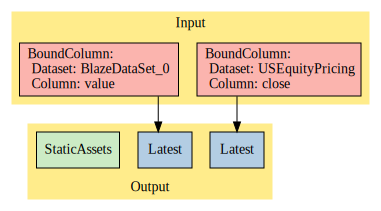

In [23]:
p.show_graph()

In [24]:
import pixiedust

Pixiedust database opened successfully


In [25]:
%%pixie_debugger
df = engine.run_pipeline(
    p,
    pd.Timestamp('2016-01-05', tz='utc'),
    pd.Timestamp('2018-08-06', tz='utc')
    #pd.Timestamp('2018-01-04', tz='utc')
)

In [ ]:
df.head()

In [ ]:
df.tail()